In [1]:
from keras.datasets import cifar10
from keras.utils import to_categorical 
import sys
import os
from typing import Tuple

sys.path.append('/home/danillorp/Área de Trabalho/github/fema/src/')


import fema_classifier
import fema_feature_learning
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

2024-03-08 20:37:03.157899: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:37:03.270470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:37:03.270558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 20:37:03.273527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 20:37:03.286947: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


In [3]:
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
train_x = np.reshape(X_train,(50000,3072))
test_x = np.reshape(X_test,(10000,3072))
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

In [5]:
train_y = y_train.reshape(y_train.shape[0],1)
test_y = y_test.reshape(y_test.shape[0],1)

In [6]:
model_fl = fema_feature_learning.FEMaFeatureLearning(k=10,basis=fema_classifier.Basis.radialBasis)

_x, eval_x, _y, eval_y = train_test_split(train_x, train_y, test_size=0.05)
print(eval_x.shape, eval_y.shape)

features_weigths = model_fl.fit(eval_x, eval_y, np.array([0]), np.array([0]))


(2500, 3072) (2500, 1)
Running:  0.0  concluded.
Running:  0.1  concluded.
Running:  0.2  concluded.
Running:  0.3  concluded.
Running:  0.4  concluded.
Running:  0.5  concluded.
Running:  0.6  concluded.
Running:  0.7  concluded.
Running:  0.8  concluded.
Running:  0.9  concluded.


In [7]:
print(train_y.shape)
print(train_y.reshape((50000,1)).shape)

(50000, 1)
(50000, 1)


In [8]:
model_fl.features_weigth.shape

(2, 10, 3072)

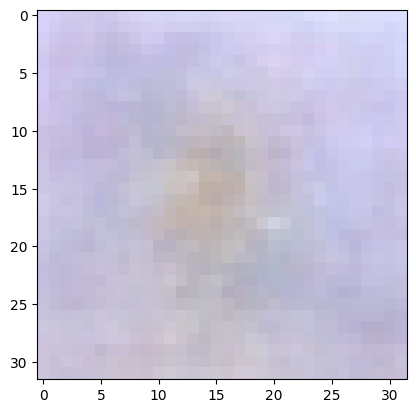

In [9]:
plt.imshow(model_fl.features_weigth[model_fl.INTRA,2].reshape(32,32,3)/np.max(model_fl.features_weigth[model_fl.INTRA,2]))

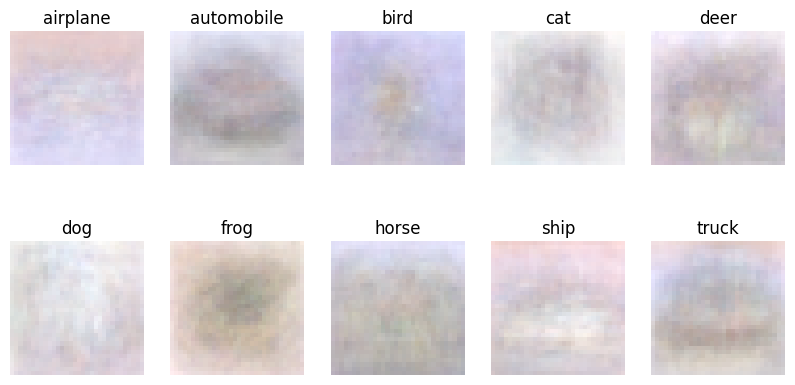

In [53]:
fig = plt.figure(figsize=(10, 5)) 
  
# setting values to rows and column variables 
rows = 2
columns = 5
    
count = 1
for r in range(rows):
    for c in range(columns):
        
        # Adds a subplot at the 1st position 
        fig.add_subplot(rows, columns, count) 
      
        # showing image         
        plt.imshow(model_fl.features_weigth[model_fl.INTRA,count-1].reshape(32,32,3)/np.max(model_fl.features_weigth[model_fl.INTRA,count-1]) )
        plt.axis('off')
        plt.title(cifar_classes[count-1])           

        count = count+1


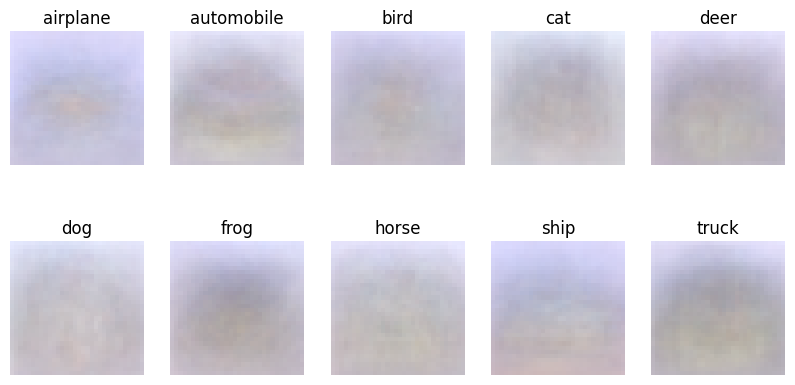

In [54]:
fig = plt.figure(figsize=(10, 5)) 
  
# setting values to rows and column variables 
rows = 2
columns = 5
    
count = 1
for r in range(rows):
    for c in range(columns):
        
        # Adds a subplot at the 1st position 
        fig.add_subplot(rows, columns, count) 
      
        # showing image         
        plt.imshow(model_fl.features_weigth[model_fl.INTER,count-1].reshape(32,32,3)/np.max(model_fl.features_weigth[model_fl.INTER,count-1]) )
        plt.axis('off')
        plt.title(cifar_classes[count-1])           

        count = count+1


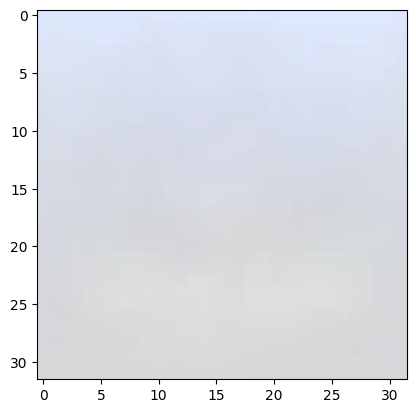

In [56]:
fl_weigths = np.zeros((model_fl.features_weigth.shape[2]))
n_classes = 10

for c in range(n_classes):
    for f in range(train_x.shape[1]):
        fl_weigths[f] = fl_weigths[f] + (features_weigths[model_fl.INTER, c, f]/features_weigths[model_fl.INTRA, c, f])/n_classes

max_w = np.max(fl_weigths)
for f in range(train_x.shape[1]):
    fl_weigths[f] = fl_weigths[f]/max_w

plt.imshow(fl_weigths.reshape(32,32,3))

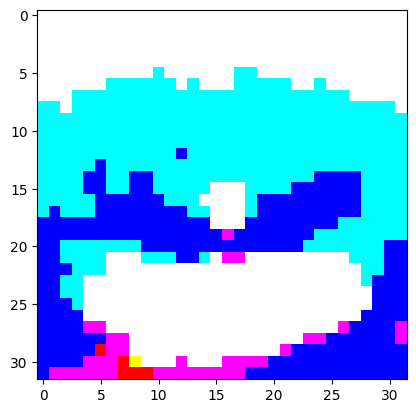

In [61]:
th = 0.85
selected_features = np.where(fl_weigths > th, 255, 0)
plt.imshow(selected_features.reshape(32,32,3))

In [62]:
np.min(fl_weigths),np.max(fl_weigths),np.mean(fl_weigths),np.median(fl_weigths)

(0.83073950225076, 1.0, 0.8714291220666025, 0.8604225163278363)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

classifiers = {'DecisionTreeClassifier()':DecisionTreeClassifier(),
               'RandomForestClassifier()':RandomForestClassifier()}


for c in classifiers:
    classifiers[c].fit(train_x,train_y)
    pred = classifiers[c].predict(test_x)

    cm = confusion_matrix(test_y,pred)
    bal = balanced_accuracy_score(test_y, pred)
    acc = accuracy_score(test_y, pred)

    print('*****',c,'*******')
    print('CM ',c,'Original:',cm)
    print('BalAcc ',c,' Original:',bal)
    print('Acc ',c,'Original:',acc)
    print('************')

In [70]:
train_x_cp = train_x.copy()
test_x_cp  = test_x.copy()

for f in range(train_x_cp.shape[1]):
    mask_inter = train_y != c
    mask_intra = train_y == c
    
    train_x_cp[:,f] =   (train_x_cp[:,f]) *  (fl_weigths[f])
    test_x_cp[:,f] =    (test_x_cp[:,f])  *  (fl_weigths[f])


In [71]:
for c in classifiers:
    classifiers[c].fit(train_x_cp,train_y)
    pred = classifiers[c].predict(test_x_cp)

    cm = confusion_matrix(test_y,pred)
    bal = balanced_accuracy_score(test_y, pred)
    acc = accuracy_score(test_y, pred)

    print('*****',c,'*******')
    print('CM ',c,'Original:',cm)
    print('BalAcc ',c,' Original:',bal)
    print('Acc ',c,'Original:',acc)
    print('************')


***** DecisionTreeClassifier() *******
CM  DecisionTreeClassifier() Original: [[347  64  91  57  67  46  35  48 160  85]
 [ 67 286  68  72  56  56  51  64 112 168]
 [ 94  62 209  86 147 116 110  77  47  52]
 [ 67  68 106 193  96 140 129  97  53  51]
 [ 65  42 163 101 225 109 117  90  43  45]
 [ 54  53 121 165  80 197 112 106  51  61]
 [ 36  45 130 124 138 104 284  66  27  46]
 [ 82  81  88  88 108  95  54 258  66  80]
 [156  98  51  47  49  39  27  45 388 100]
 [ 94 178  51  77  47  55  59  71  89 279]]
BalAcc  DecisionTreeClassifier()  Original: 0.2666
Acc  DecisionTreeClassifier() Original: 0.2666
************


/home/danillorp/.local/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [ ]:
np.min(fl_weigths), np.max(fl_weigths), np.mean(fl_weigths), np.median(fl_weigths)

In [ ]:
th = 0.86
selected_features = np.where(fl_weigths > th, True, False)
plt.imshow(selected_features.reshape((32,32,3)).astype(np.float32))

In [ ]:
print(train_x.shape,train_x[:,selected_features].shape)

In [ ]:
for c in classifiers:
    classifiers[c].fit(train_x_cp[:,selected_features],train_y)
    pred = classifiers[c].predict(test_x_cp[:,selected_features])

    cm = confusion_matrix(test_y,pred)
    bal = balanced_accuracy_score(test_y, pred)
    acc = accuracy_score(test_y, pred)

    print('*****',c,'*******')
    print('CM ',c,'Original:',cm)
    print('BalAcc ',c,' Original:',bal)
    print('Acc ',c,'Original:',acc)
    print('************')


In [ ]:
train_x_cp = train_x.copy()
test_x_cp  = test_x.copy()


for c in classifiers:
    classifiers[c].fit(train_x_cp[:,selected_features],train_y)
    pred = classifiers[c].predict(test_x_cp[:,selected_features])

    cm = confusion_matrix(test_y,pred)
    bal = balanced_accuracy_score(test_y, pred)
    acc = accuracy_score(test_y, pred)

    print('*****',c,'*******')
    print('CM ',c,'Original:',cm)
    print('BalAcc ',c,' Original:',bal)
    print('Acc ',c,'Original:',acc)
    print('************')
